In [1300]:
import numpy as np
import pandas as pd
import math
import missingno as mso
from datetime import datetime, timedelta
from datetime import datetime
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [1370]:
df = pd.read_csv('telecom_users.csv')

заменим категориальные значения

In [1371]:
#заменим категориальные значения
df = df.replace(['Yes','No'], [1,0])   
df = df.replace(['Credit card (automatic)','Bank transfer (automatic)', 'Mailed check', 'Electronic check'], [0,1,2,3])
df = df.replace('No phone service', 2)
df = df.replace(['Fiber optic','DSL'], [1,2])
df = df.replace(['Month-to-month','One year','Two year'], [0,1,2])
df = df.replace(['Male','Female'], [1,0])
df = df.replace('No internet service', 2)

In [1372]:
# переводим TotalCharges в float
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric, errors='coerce') 


In [1373]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix,recall_score
import xgboost as xgb   
from sklearn.metrics import precision_score

Разбиваем датасет на фичи и таргет

In [1374]:

X4 = df.iloc[:,2:21].fillna(value = 2)  
target = df['Churn'].values


In [1375]:
target.sum()/len(target)  # Датасет несбалансирован, 0 больше, чем 1

0.2651186100902105

формируем тренировочную и валидационную выборку

In [1376]:

x_train2, x_test2, y_train2, y_test2 = train_test_split(X4, target, test_size=.3, stratify=target, random_state=17) 

In [1377]:
X4.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,0,1,1,72,1,1,0,2,2,2,2,2,2,2,0,0,24.10,1734.65
1,0,0,0,0,44,1,0,1,0,1,1,0,1,0,0,1,0,88.15,3973.20
2,0,1,1,0,38,1,1,1,0,0,0,0,0,0,0,1,1,74.95,2869.85
3,1,0,0,0,4,1,0,2,0,0,0,0,0,1,0,1,3,55.90,238.50
4,1,0,0,0,2,1,0,2,1,0,1,0,0,0,0,0,3,53.45,119.50


Выбираем xgboost, логистическую регрессию, так как решаем задачу классификации.

In [1378]:

dtrain2 = xgb.DMatrix(x_train2, y_train2)    
dtest2 = xgb.DMatrix(x_test2, y_test2)

params = {'objective': 'binary:logistic',
          'max_depth': 2,
          'eta': 0.14}

num_rounds = 60


evals = [(dtest2, 'test'), (dtrain2,'train')]
xgb_model2 = xgb.train(params, dtrain2, num_rounds, evals)

[0]	test-error:0.25167	train-error:0.258711
[1]	test-error:0.223831	train-error:0.221002
[2]	test-error:0.236637	train-error:0.22506
[3]	test-error:0.236637	train-error:0.22506
[4]	test-error:0.236637	train-error:0.22506
[5]	test-error:0.203229	train-error:0.205012
[6]	test-error:0.208797	train-error:0.206921
[7]	test-error:0.208241	train-error:0.206921
[8]	test-error:0.208797	train-error:0.20716
[9]	test-error:0.20657	train-error:0.205967
[10]	test-error:0.206013	train-error:0.205728
[11]	test-error:0.20657	train-error:0.205967
[12]	test-error:0.205457	train-error:0.205967
[13]	test-error:0.206013	train-error:0.205967
[14]	test-error:0.20657	train-error:0.205728
[15]	test-error:0.203229	train-error:0.204296
[16]	test-error:0.2049	train-error:0.204773
[17]	test-error:0.205457	train-error:0.204057
[18]	test-error:0.206013	train-error:0.204773
[19]	test-error:0.208241	train-error:0.200239
[20]	test-error:0.207684	train-error:0.200239
[21]	test-error:0.204343	train-error:0.200955
[22]	tes

In [1379]:
# xgboost предсказал 85% результатов правильно
prediction2 = xgb_model2.predict(dtest2)   
result2 = (prediction2 > 0.5).astype(int)

roc_auc_score(y_test2, prediction2)

0.8534313725490197

In [1380]:
confusion_matrix(y_test2, result2)

array([[1213,  107],
       [ 247,  229]], dtype=int64)

In [1381]:
# однако xgboost плохо предсказал  отток, в данном случае нам намного важнее полнота, так как важнее знать именно тех, кто перестал пользоваться услугами
recall_score(y_test2, result2 ) 

0.4810924369747899

Находим самые важные фичи на основании того, как часто делалось разбиение по данному признаку

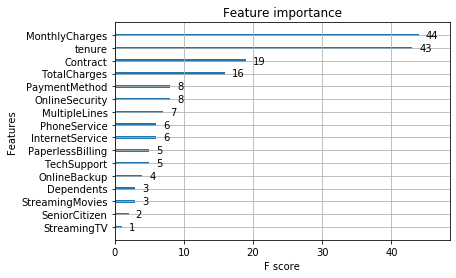

In [1382]:

xgb.plot_importance(xgb_model2) 

In [1383]:
df2 = df[['Churn','tenure','MonthlyCharges']]  
df2[df2['Churn']==1]['MonthlyCharges'].median()


79.5

In [1384]:
df2[df2['Churn']==0]['MonthlyCharges'].apply(['median','mean','min','max'])

median     64.750000
mean       61.424506
min        18.250000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [1385]:
df2[df2['Churn']==1]['MonthlyCharges'].apply(['median','mean','min','max'])
# Видно, что средняя месячная плата выше у тех, кто отказался от услуг

median     79.500000
mean       74.164871
min        18.850000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [1386]:
df2[df2['Churn']==0]['tenure'].apply(['median','mean','min','max'])

median    37.000000
mean      37.599682
min        0.000000
max       72.000000
Name: tenure, dtype: float64

In [1387]:
df2[df2['Churn']==1]['tenure'].apply(['median','mean','min','max'])
# Видно, что отток произошел среди относительно новых клиентов

median    10.000000
mean      18.246377
min        1.000000
max       72.000000
Name: tenure, dtype: float64

Попробуем использовать только самые важные фичи

In [1388]:

X = df[['tenure','TotalCharges', 'MonthlyCharges','Contract']].fillna(value=0).values 

Разбиваем датаест на тренировочный и валидационный. Указываем stratify=y, чтобы сохранить долю классов

In [1389]:

x_train, x_test, y_train, y_test =  train_test_split(X, target, test_size=0.25, stratify=target, random_state=17)  

In [1390]:
xgb_model = xgb.train(params, dtrain, num_rounds)
 

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth':3,
          'eta': 0.14}

num_rounds = 70

Получаем долю правильных предсказаний на xgboost

In [1391]:

prediction = xgb_model.predict(dtest)   
result = (prediction > 0.5).astype(int)

roc_auc_score(y_test, prediction)

0.8365651476986489

In [1392]:
precision_score(y_test, result) 

0.6607142857142857

In [1393]:
# получаем полноту. Очень низкий, плохо предсказываем отток
recall_score(y_test, result)   

0.4659949622166247

In [1394]:
# рисуем матрицу ошибок
confusion_matrix(y_test, result) 

array([[1005,   95],
       [ 212,  185]], dtype=int64)

Посмотрим, как базовые алгориты, опирающиеся на основные фичи, выявленные с помощью xgboost предсказывают отток

Так как мы решаем задачу классификации, выбираем соответствующие алгоритмы

In [1395]:

knn = KNeighborsClassifier(n_neighbors=3) 
knn_model = knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)
knn_predictions

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [1396]:
roc_auc_score(y_test, knn_predictions)

0.6629688573391344

In [1397]:
recall_score(y_test, knn_predictions)

0.48866498740554154

In [1398]:
accuracy_score(y_test, knn_predictions)

0.7448229792919172

In [1399]:
nb = GaussianNB()

nb_model = nb.fit(x_train,y_train)

nb_predictions = nb.predict(x_test)
nb_predictions

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [1400]:
recall_score(y_test, nb_predictions) 
# Наивный Байесовский классификатор относительно хорошо предсказал переставших пользоваться услугами людей

0.7858942065491183

In [1401]:
nb.score(x_test,y_test)

0.687374749498998

In [1402]:
confusion_matrix(y_test, nb_predictions)  

array([[717, 383],
       [ 85, 312]], dtype=int64)

In [1403]:
roc_auc_score(y_test, nb.predict_proba(x_test)[:,1])

0.8046759789329059

In [1404]:
dtc = DecisionTreeClassifier()

dtc_model = dtc.fit(x_train,y_train)

dtc_predictions = dtc.predict(x_test)
dtc_predictions

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [1405]:
recall_score(y_test, dtc_predictions)

0.5012594458438288

In [1406]:
lreg = LogisticRegression(random_state=17)

lreg_model = lreg.fit(x_train,y_train)

lreg_predictions = lreg.predict(x_test)
lreg_predictions

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [1407]:
recall_score(y_test, lreg_predictions)

0.491183879093199

Пробуем улучшить предсказания с помощью стэкинга

In [1408]:

def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test, test_size=None, cv=5):  
    if test_size is None:
        
    
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        
        for n, model in enumerate(models):
            
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv,  method='predict')
            model.fit(data_train, targets_train)
       
        meta_model = meta.fit(meta_mtrx,targets_test)
        
        meta_mtrx_test = np.empty((x_test.shape[0], len(models))) 
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(y_test, meta_predict)}')
            print(f'Recall_score: {recall_score(y_test, meta_predict)}')
    
    elif test_size > 0 and test_size < 1:
        train, valid, train_true, valid_true = train_test_split(x_train, 
                                                        y_train,
                                                        train_size=None,
                                                        random_state=None)
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        
        
        for n, model in enumerate(models):
            model.fit(x_train,y_train)
            meta_mtrx[:, n] = model.predict(valid)
        
        meta_model = meta.fit(meta_mtrx, valid_true)
        
        meta_mtrx_test = np.empty((x_test.shape[0], len(models))) 
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(y_test, meta_predict)}')
            print(f'Recall_score: {recall_score(y_test, meta_predict)}')
    
    else:
        raise ValueError("test_size must be between 0 and 1")

In [1409]:
models = [nb,dtc,knn,lreg]

meta = XGBClassifier(n_estimators=60, max_iter = 1500)

In [1410]:
# Stacking не дал хороших результатов
stacking(models, meta, x_train, y_train, x_test, y_test, test_size = 0.3) 

Stacking AUC: 0.649578658117701
Recall_score: 0.49370277078085645


In [1411]:
stacking(models1, meta, x_train, y_train, x_test, y_test, test_size = 0.3)

Stacking AUC: 0.6446450652621938
Recall_score: 0.4811083123425693


In [1412]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD


Пробуем ужать данные, чтоб избавиться от выбросов и убрать линейно зависимые фичи.

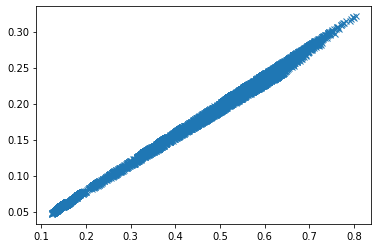

In [1413]:

svd_model = TruncatedSVD(n_components=2).fit(X4)   
X_svd = svd_model.transform(X4)
X_svd_restored = svd_model.inverse_transform(X_svd)
plt.plot(X_svd_restored[:,0], X_svd_restored[:,1], 'x')
plt.show()

In [1414]:
def eval_model(input_x, input_y):
    """Обучаем и валидируем модель"""
    X_train, X_test, y_train, y_test = train_test_split(
        input_x, input_y, test_size=.3, stratify=target, random_state=42
    )
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    acc_score = accuracy_score(y_test, preds.argmax(axis=1))
    roc_score = roc_auc_score(y_test, preds.argmax(axis=1))
    rec_score = recall_score(y_test, preds.argmax(axis=1))
    print('Accuracy: %.5f' % acc_score, 'roc_score: %.5f'% roc_score, 'rec_score:%.5f'% rec_score)

In [1415]:
eval_model(X_svd, target)

Accuracy: 0.78675 roc_score: 0.64806 rec_score:0.35294


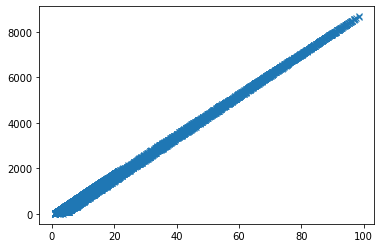

In [1416]:
svd_model1 = TruncatedSVD(n_components=2).fit(X)
X_svd1 = svd_model1.transform(X)
X_svd_restored1 = svd_model1.inverse_transform(X_svd1)
plt.plot(X_svd_restored1[:,0], X_svd_restored1[:,1], 'x')
plt.show()

In [1419]:
eval_model(X_svd1, target)

Accuracy: 0.78675 roc_score: 0.64873 rec_score:0.35504


 Наилучший результат дал gboost, попробуем оптимизирвать алгоритм, используя на новом датасете.

In [1418]:
data = pd.read_csv('telecom_users.csv')

In [1420]:
data.drop('customerID', axis=1, inplace=True)

In [1421]:
data.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,Female,0,No,No,44,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,Male,0,No,No,4,Yes,No,DSL,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,Male,0,No,No,2,Yes,No,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [1422]:
len(data.loc[data['TotalCharges']==' '])

10

In [1423]:
data.loc[data['TotalCharges']==' '] #клиенты только оформили услуги, с них еще не взяли плату, можно заменить TotalCharges на 0

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,753,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [1424]:
data.loc[(data['TotalCharges']==' '), 'TotalCharges'] = 0  

In [1425]:
data.loc[data['tenure']==0]

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0,No
634,1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
2771,3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
3086,5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
3255,3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
4326,936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
5375,753,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
5382,4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5695,488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
5951,1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No


In [1426]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges']) # Переводим TotalCharges в float

In [1427]:
X5 = data.drop('Churn', axis=1).copy() # Формируем фичи
X5.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1869,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65
1,4528,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20
2,6344,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85
3,6739,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50
4,432,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50


In [1428]:
y = data['Churn'].copy() # формируем таргет
y = y.replace(['Yes','No'], [1,0])# нужно заменить на 0 и 1
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

кодируем категорийные данные, используя One-Hot encoding. Так как, если мы кодируем категорийные данные вручную, 
например Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic) как [1,2,3,4],
то классификатор будет определять 1 более похожим на 2, чем, например, 1 на 4, что может сказаться на качестве.

In [1429]:

X_encoded = pd.get_dummies(X5, columns = ['gender',   
                                        'Partner',
                                        'Dependents',
                                        'PhoneService',
                                        'MultipleLines',
                                        'InternetService',
                                        'OnlineSecurity',
                                        'OnlineBackup',
                                        'DeviceProtection',
                                        'TechSupport',
                                        'StreamingTV',
                                        'StreamingMovies',
                                        'Contract',
                                        'PaperlessBilling',
                                        'PaymentMethod',
                                        ])
X_encoded.head()

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1869,0,72,24.10,1734.65,0,1,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,4528,0,44,88.15,3973.20,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,6344,1,38,74.95,2869.85,1,0,0,1,1,...,0,1,0,0,0,1,1,0,0,0
3,6739,0,4,55.90,238.50,0,1,1,0,1,...,1,1,0,0,0,1,0,0,1,0
4,432,0,2,53.45,119.50,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [1430]:
x_train5, x_test5, y_train5, y_test5 =  train_test_split(X_encoded, y,  stratify=y, random_state=42) #указываем stratify=y, чтобы сохранить долю классов

Выбираем логистическую регрессию, т.к решаем задачу классификации

In [1431]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',  seed =42) 
clf_xgb.fit(x_train5,
            y_train5, 
            verbose = True,
            early_stopping_rounds =10,
            eval_metric ='aucpr',
            eval_set = [(x_test5, y_test5)])

[0]	validation_0-aucpr:0.529472
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.585019
[2]	validation_0-aucpr:0.597952
[3]	validation_0-aucpr:0.603345
[4]	validation_0-aucpr:0.608032
[5]	validation_0-aucpr:0.609826
[6]	validation_0-aucpr:0.614797
[7]	validation_0-aucpr:0.617059
[8]	validation_0-aucpr:0.638326
[9]	validation_0-aucpr:0.637694
[10]	validation_0-aucpr:0.6418
[11]	validation_0-aucpr:0.640931
[12]	validation_0-aucpr:0.641474
[13]	validation_0-aucpr:0.64308
[14]	validation_0-aucpr:0.642871
[15]	validation_0-aucpr:0.648897
[16]	validation_0-aucpr:0.650264
[17]	validation_0-aucpr:0.650801
[18]	validation_0-aucpr:0.652839
[19]	validation_0-aucpr:0.653409
[20]	validation_0-aucpr:0.654043
[21]	validation_0-aucpr:0.652892
[22]	validation_0-aucpr:0.654761
[23]	validation_0-aucpr:0.656208
[24]	validation_0-aucpr:0.652975
[25]	validation_0-aucpr:0.653451
[26]	validation_0-aucpr:0.653727
[27]	validation_0-aucpr:0.654582
[28]	validation_0-aucpr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

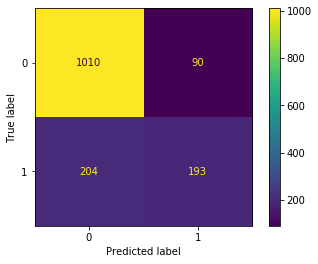

In [1432]:
#Рисуем матрицу ошибок. Больше половины оттока классифицирована неверно, нужно подкрутить веса.
plot_confusion_matrix (clf_xgb, x_test5, y_test5,values_format='d' ) 

In [1433]:
predictions = clf_xgb.predict_proba(x_test5)
print ('ROC AUC Score',roc_auc_score(y_test5,predictions[:,1]))

ROC AUC Score 0.8423391344172202


In [1434]:
predictions3 = clf_xgb.predict(x_test5)
recall_score(y_test5,predictions3)

0.48614609571788414

In [1435]:

precision_score(y_test5,predictions3)

0.6819787985865724

Чтобы улучшить полноту увеличиваем веса, устанавливаем scale_pos_weight = 50.

In [1436]:

clf_xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                            seed =42,
                            max_depth = 4,
                            scale_pos_weight = 50
                           ) 
clf_xgb1.fit(x_train5,
            y_train5, 
            verbose = True,
            early_stopping_rounds =10,
            eval_metric ='aucpr',
            eval_set = [(x_test5, y_test5)])

[0]	validation_0-aucpr:0.532332
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.537551
[2]	validation_0-aucpr:0.537569
[3]	validation_0-aucpr:0.579066
[4]	validation_0-aucpr:0.579209
[5]	validation_0-aucpr:0.577928
[6]	validation_0-aucpr:0.585789
[7]	validation_0-aucpr:0.582327
[8]	validation_0-aucpr:0.582309
[9]	validation_0-aucpr:0.580625
[10]	validation_0-aucpr:0.580806
[11]	validation_0-aucpr:0.582363
[12]	validation_0-aucpr:0.582245
[13]	validation_0-aucpr:0.584536
[14]	validation_0-aucpr:0.584417
[15]	validation_0-aucpr:0.588985
[16]	validation_0-aucpr:0.588021
[17]	validation_0-aucpr:0.589695
[18]	validation_0-aucpr:0.607817
[19]	validation_0-aucpr:0.609552
[20]	validation_0-aucpr:0.609424
[21]	validation_0-aucpr:0.610318
[22]	validation_0-aucpr:0.608867
[23]	validation_0-aucpr:0.611854
[24]	validation_0-aucpr:0.614093
[25]	validation_0-aucpr:0.614311
[26]	validation_0-aucpr:0.614594
[27]	validation_0-aucpr:0.615698
[28]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, seed=42,
              silent=None, subsample=1, verbosity=1)

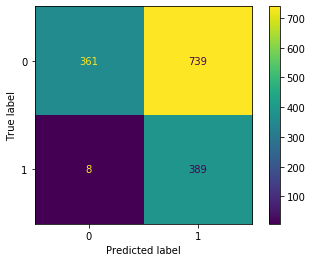

In [1437]:
plot_confusion_matrix (clf_xgb1, x_test5, y_test5,values_format='d' ) 

In [1438]:
predictions1 = clf_xgb1.predict_proba(x_test5)
print ('ROC AUC Score',roc_auc_score(y_test5,predictions1[:,1]))

ROC AUC Score 0.8333684451568583


In [1439]:
predictions2 = clf_xgb1.predict(x_test5)


In [1440]:

recall_score(y_test5,predictions2)

0.9798488664987406

In [1441]:
roc_auc_score(y_test5,predictions2)

0.6540153423402794

In [1442]:
precision_score(y_test5,predictions2)

0.3448581560283688

В данном случае полнота нам более важна, чем точность. Увеличив веса, удалось улучшить полноту, то есть более точно спрогнозировать, кто из клиентов вероятнее всего перестанет пользоваться услугами. 

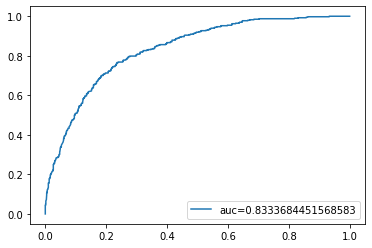

In [1443]:

probas = clf_xgb1.predict_proba(x_test5)
fpr, tpr, _ = roc_curve(y_test5, probas[:, 1])
auc = roc_auc_score(y_test5, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)

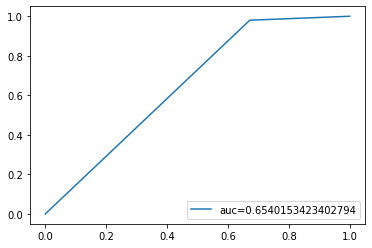

In [1444]:
probas1 = clf_xgb1.predict(x_test5)
fpr, tpr, _ = roc_curve(y_test5, probas1)
auc = roc_auc_score(y_test5, probas1)
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)